In [1]:
!pip install sk-video

    100% |################################| 2.3MB 427kB/s 
You are using pip version 8.1.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


In [22]:
!mkdir clean_data
!mkdir clean_data/train_imgs
!mkdir clean_data/test_imgs

In [3]:
# constants
DATA_PATH = 'data/'

TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4')
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')

CLEAN_DATA_PATH = 'clean_data/'
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs')
CLEAN_IMGS_TEST = os.path.join(CLEAN_DATA_PATH, 'test_imgs')

train_frames = 20400
test_frames = 10798

[autoreload of six failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'RobotFileParser'
]


In [4]:
def capture_frames(video_source, speed_data):
    
    '''
    Captures .mp4 video frames to .jpg images and creates a .csv to store the capture information
    '''
    
    num_frames = speed_data.shape[0]
    
    # create VideoCapture instance
    cap = cv2.VideoCapture(video_source)
    # set frame count
    cap.set(cv2.CAP_PROP_FRAME_COUNT, num_frames)
    
    with open('./data/train_meta.csv', 'w') as csvfile:
        fieldnames = ['image_path', 'frame', 'time', 'speed']
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()

        for idx in range(num_frames):
            # set frame index
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000

            # read the frame
            success, image = cap.read()

            if success:
                image_path = os.path.join('./data/IMG/', str(idx) + '.jpg')

                # save image to IMG folder
                cv2.imwrite(image_path, image)

                # write row to driving.csv
                writer.writerow({'image_path': image_path,
                         'frame': idx,
                         'time': time,
                         'speed': speed_data[idx],
                        })
            else:
                print('Failed to read frame ', idx)
        
        print('Done!')

In [ ]:
capture_frames('data/train.mp4', np.loadtxt('data/train.txt'))

In [ ]:
def dataset_constructor(video_loc, img_folder, tot_frames, dataset_type):
    meta_dict = {}

    tqdm.write('reading in video file...')
    tot_frames = train_frames
    cap = skvideo.io.vread(video_loc)
     
    tqdm.write('constructing dataset...')
    for idx, frame in enumerate(tqdm(cap)):    
        img_path = os.path.join(img_folder, str(idx)+'.jpg')
        frame_speed = float('NaN') if dataset_type == 'test' else train_y[idx]
        meta_dict[idx] = [img_path, idx, frame_speed]
        skvideo.io.vwrite(img_path, frame)
    meta_df = pd.DataFrame.from_dict(meta_dict, orient='index')
    meta_df.columns = ['image_path', 'image_index', 'speed']
    
    tqdm.write('writing meta to csv')
    meta_df.to_csv(os.path.join(CLEAN_DATA_PATH, dataset_type+'_meta.csv'), index=False)
    
    return "done dataset_constructor"

In [ ]:
# test data
dataset_constructor(TEST_VIDEO, CLEAN_IMGS_TEST, test_frames, 'test')

In [4]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

('shape: ', (20400, 4))


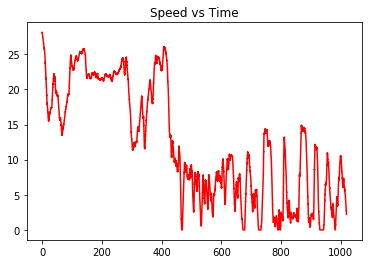

In [5]:
times = np.asarray(train_meta['time'], dtype = np.float32)
speeds = np.asarray(train_meta['speed'], dtype=np.float32)

plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.show()

In [6]:
def batch_shuffle(dframe):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(dframe) - 1):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [7]:
train_data, valid_data = batch_shuffle(train_meta)

In [8]:
print('valid_data: ', len(valid_data))
print('train_data: ', len(train_data))

('valid_data: ', 9116)
('train_data: ', 31682)


In [9]:
train_data.head(5)

,index,image_path,frame,time,speed
0,5193,./data/IMG/5193.jpg,5193,259.65,22.861871
0,5194,./data/IMG/5194.jpg,5194,259.70,22.857198
0,19242,./data/IMG/19242.jpg,19242,962.10,7.221492
0,19243,./data/IMG/19243.jpg,19243,962.15,7.119820
0,870,./data/IMG/870.jpg,870,43.50,20.918166


In [10]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [11]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [12]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:440, :-90] # -> (380, 550, 3)
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [13]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

In [14]:
def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [15]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['time'].values[0]
            time_prev = row_prev['time'].values[0]
            time_next = row_next['time'].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
                # in this case row_prev is x1 and row_now is x2
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
                # in this case row_now is x1 and row_next is x2
                row1 = row_now
                row2 = row_next
                
                # Use this to find outliers
            else:
                print('time_now is not next or prev: ', time_now)
                print('time_prev is :', time_prev)
                print('time_next is: ', time_next)
                
                print('\n diff: now  - prev \t', time_now - time_prev)
                print('\n diff: next - now: \t', time_next - time_now)
            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
            
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [16]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['time'].values[0]
            time_prev = row_prev['time'].values[0]
            time_next = row_next['time'].values[0]
            
            if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58:
                # in this case row_prev is x1 and row_now is x2
                row1 = row_prev
                row2 = row_now
                
            elif time_next - time_now > 0 and 0.000001 < time_next - time_now < 0.58:
                # in this case row_now is x1 and row_next is x2
                row1 = row_now
                row2 = row_next
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            yield img_diff, speed

In [17]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF


N_img_height = 66
N_img_width = 220
N_img_channels = 3

def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [18]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)

BATCH = 16
print('val_size: ', val_size)

('val_size: ', 9116)


In [164]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = 'model-weights-Vtest3-28.h5'

# earlyStopping = EarlyStopping(monitor='val_loss', 
#                               patience=1, 
#                               verbose=1, 
#                               min_delta = 0.23,
#                               mode='min',)

modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

callbacks_list = [modelCheckpoint]

In [165]:
model = nvidia_model()

In [166]:
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, BATCH)

In [167]:
model.load_weights('model-weights-Vtest3-27.h5')

In [168]:
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 100,
    callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/100
400/400 [==============================] - 343s 857ms/step - loss: 0.0960 - val_loss: 0.0808

Epoch 00001: val_loss improved from inf to 0.08084, saving model to model-weights-Vtest3-28.h5
Epoch 2/100
400/400 [==============================] - 338s 844ms/step - loss: 0.1094 - val_loss: 0.1147

Epoch 00002: val_loss did not improve from 0.08084
Epoch 3/100
400/400 [==============================] - 338s 846ms/step - loss: 0.1270 - val_loss: 0.0992

Epoch 00003: val_loss did not improve from 0.08084
Epoch 4/100
400/400 [==============================] - 339s 847ms/step - loss: 0.1043 - val_loss: 0.0873

Epoch 00004: val_loss did not improve from 0.08084
Epoch 5/100
400/400 [==============================] - 340s 850ms/step - loss: 0.0955 - val_loss: 0.0772

Epoch 00005: val_loss improved from 0.08084 to 0.07725, saving model to model-weights-Vtest3-28.h5
Epoch 6/100
400/400 [==============================] - 340s 851ms/step - loss: 0.0887 - val_loss: 0.0731

Epoch 00006: val_

In [169]:
model.load_weights('model-weights-Vtest3-28.h5')

In [170]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

('val score:', 0.0546116621559757)


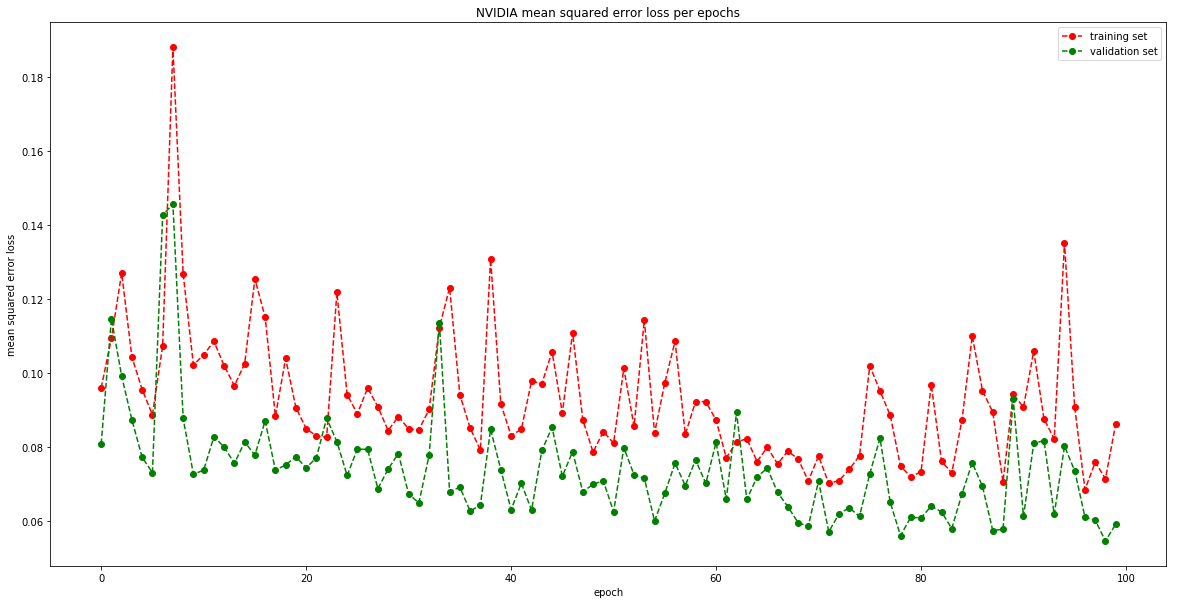

In [171]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')

plt.ylabel('mean squared error loss')
plt.xlabel('epoch')

plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

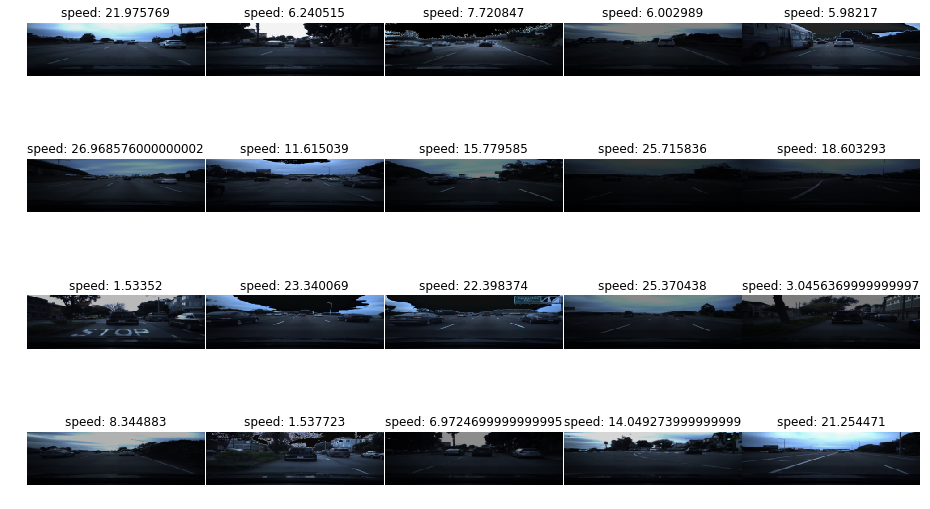

In [172]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    bright_factor = 0.2 + np.random.uniform()
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_from_path(row['image_path'].values[0], row['speed'].values[0], bright_factor)
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'speed: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

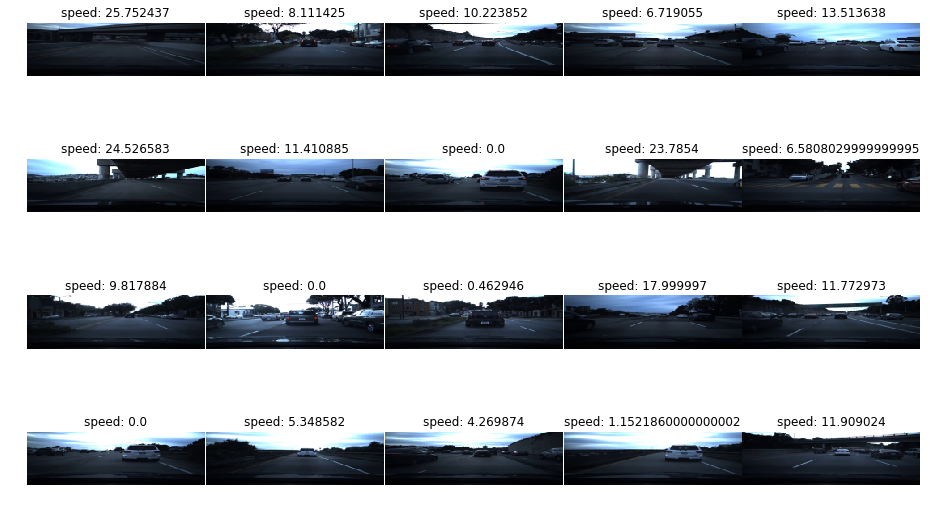

In [173]:
# random selection
data = valid_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_valid_from_path(row['image_path'].values[0], row['speed'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'speed: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

In [174]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['frame'].values[0]
        time_prev = row_prev['frame'].values[0]
        time_next = row_next['frame'].values[0]
        
        def inner():
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])

            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])

            prediction = model.predict(img_diff)
            error = abs(prediction-y2)

            #print(prediction, error, time_now)
            data.loc[data['frame']==time_now, 'predicted_speed'] = prediction[0][0]
            data.loc[data['frame']==time_now, 'error'] = error[0][0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
            inner()
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
            inner()

In [175]:
make_predictions(valid_data)

100%|██████████| 9114/9114 [04:03<00:00, 37.39it/s]


In [179]:
valid_data.head()

,index,image_path,frame,time,speed,predicted_speed,error
0,10372,./data/IMG/10372.jpg,10372,518.60,5.551958,5.415774,0.136184
0,10373,./data/IMG/10373.jpg,10373,518.65,5.593232,5.623007,0.029775
0,16587,./data/IMG/16587.jpg,16587,829.35,2.739208,2.338275,0.400933
0,16588,./data/IMG/16588.jpg,16588,829.40,2.757598,2.855805,0.098207
0,11143,./data/IMG/11143.jpg,11143,557.15,5.887374,6.015949,0.184567


In [180]:
print(mean_squared_error(valid_data.iloc[1:-1, 4], 
                         valid_data.iloc[1:-1, 5]))

0.055768175855741654


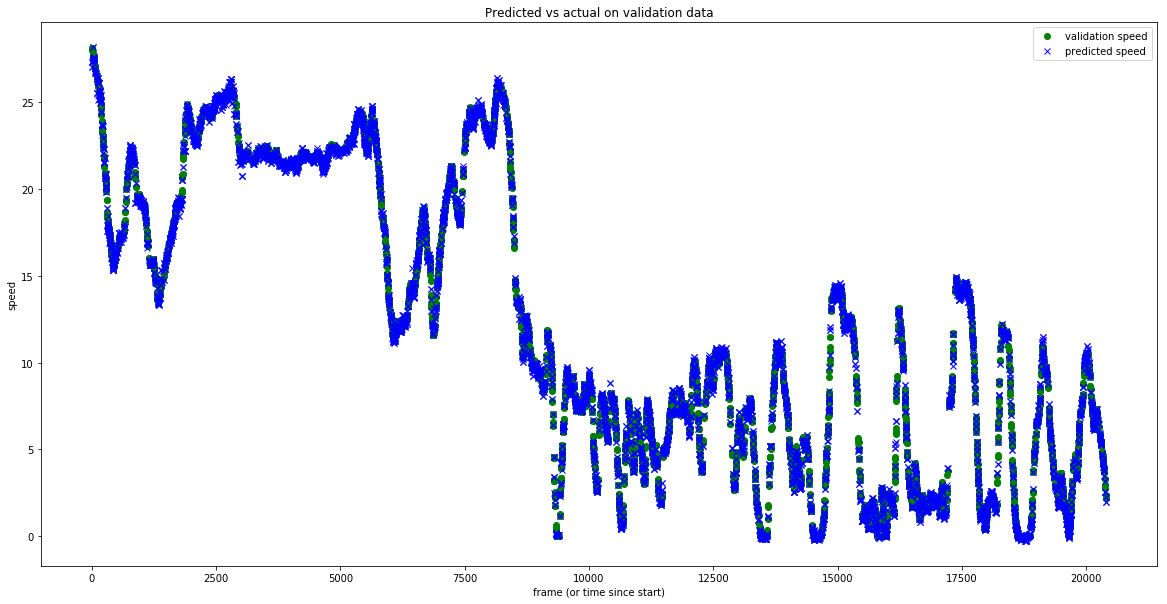

In [181]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['frame'])[['frame']], 
         valid_data.sort_values(['frame'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['frame'])[['frame']], 
         valid_data.sort_values(['frame'])[['predicted_speed']], 'bx')
plt.xlabel('frame (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

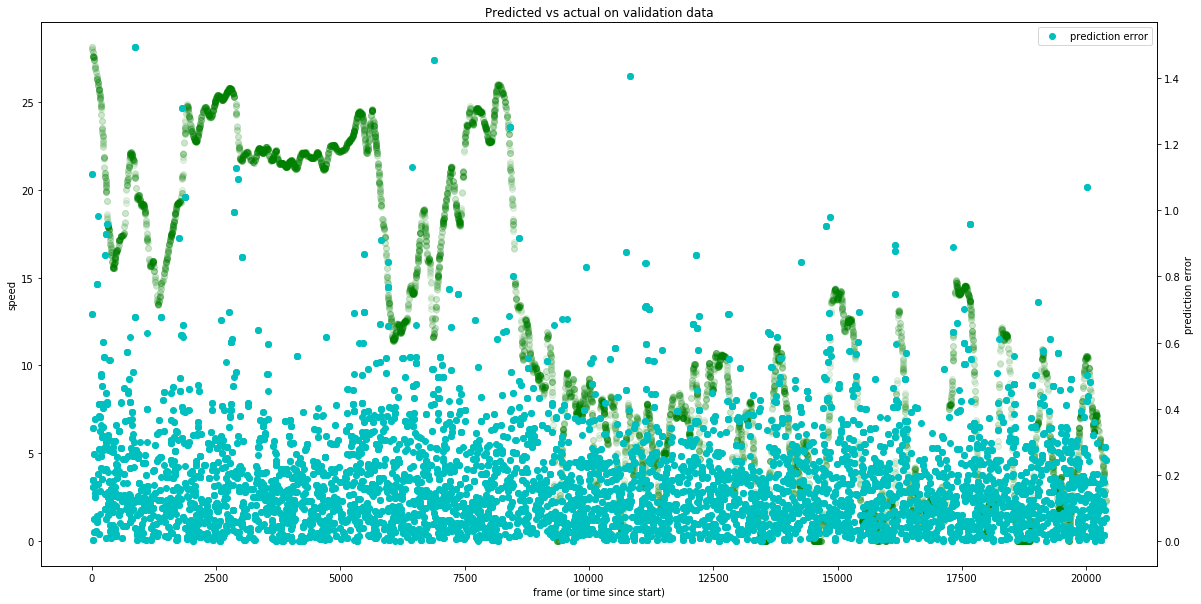

In [183]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['frame'])[['frame']], 
         valid_data.sort_values(['frame'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['frame'])[['frame']], 
         valid_data.sort_values(['frame'])[['error']], 'co')

ax1.set_xlabel('frame (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

In [184]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(valid_data.sort_values(['frame'])[['frame']], 
             valid_data.sort_values(['frame'])[['speed']], 'go', alpha=0.4)


    ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['frame'])[['frame']], 
             valid_data[valid_data['error']>error_thresh].sort_values(['frame'])[['speed']], 'rx')


    ax.set_xlabel('frame (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIuMCwgZGVzY3JpcHRpb249dSdlcnJvcl90aHJlc2gnLCBtYXg9NS4wKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHXigKY=


<function __main__.error_analysis>

In [185]:
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))

assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)

print('shape: ', test_meta.shape)

('shape: ', (10798, 3))


In [186]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        def inner():
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])

            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])

            prediction = model.predict(img_diff)
            error = abs(prediction-y2)

            #print(prediction, error, time_now)
            data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
            data.loc[data['image_index']==time_now, 'error'] = error[0][0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
            inner()
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
            inner()

In [187]:
make_predictions(test_meta)

100%|██████████| 10796/10796 [04:42<00:00, 38.19it/s]


In [188]:
test_meta.head()

,image_path,image_index,speed,predicted_speed,error
0,clean_data/test_imgs/0.jpg,0,NaN,NaN,NaN
1,clean_data/test_imgs/1.jpg,1,NaN,20.047270,NaN
2,clean_data/test_imgs/2.jpg,2,NaN,19.577244,NaN
3,clean_data/test_imgs/3.jpg,3,NaN,17.996094,NaN
4,clean_data/test_imgs/4.jpg,4,NaN,19.958094,NaN


In [189]:
window_size = 25
test_meta['smooth_predicted_speed'] = test_meta['predicted_speed'].rolling(window_size, min_periods=1).mean()
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

In [190]:
test_meta.head()

,image_path,image_index,speed,predicted_speed,error,smooth_predicted_speed,smooth_error
0,clean_data/test_imgs/0.jpg,0,NaN,NaN,NaN,NaN,NaN
1,clean_data/test_imgs/1.jpg,1,NaN,20.047270,NaN,20.047270,NaN
2,clean_data/test_imgs/2.jpg,2,NaN,19.577244,NaN,19.812257,NaN
3,clean_data/test_imgs/3.jpg,3,NaN,17.996094,NaN,19.206869,NaN
4,clean_data/test_imgs/4.jpg,4,NaN,19.958094,NaN,19.394675,NaN


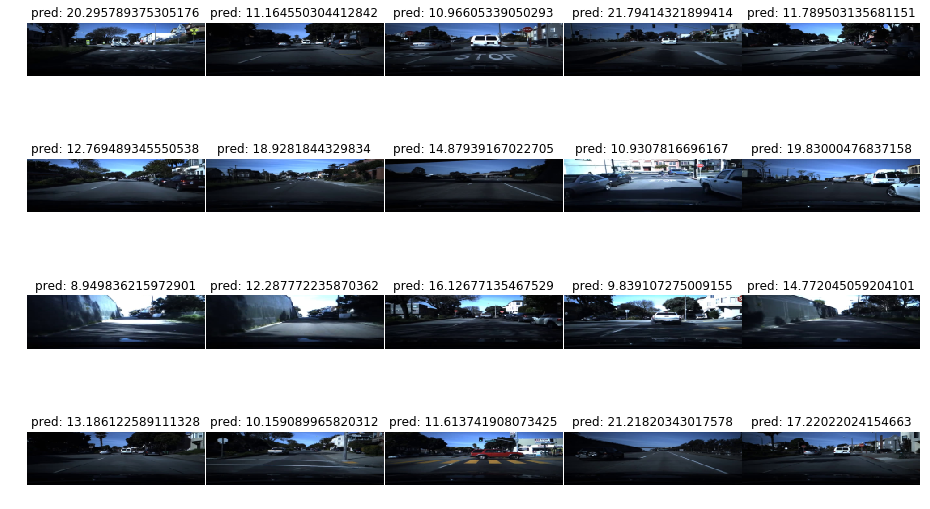

In [210]:
# random selection
data = test_meta
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row = data.iloc[[idx]].reset_index()
    x, y = preprocess_image_valid_from_path(row['image_path'].values[0], row['smooth_predicted_speed'].values[0])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'pred: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

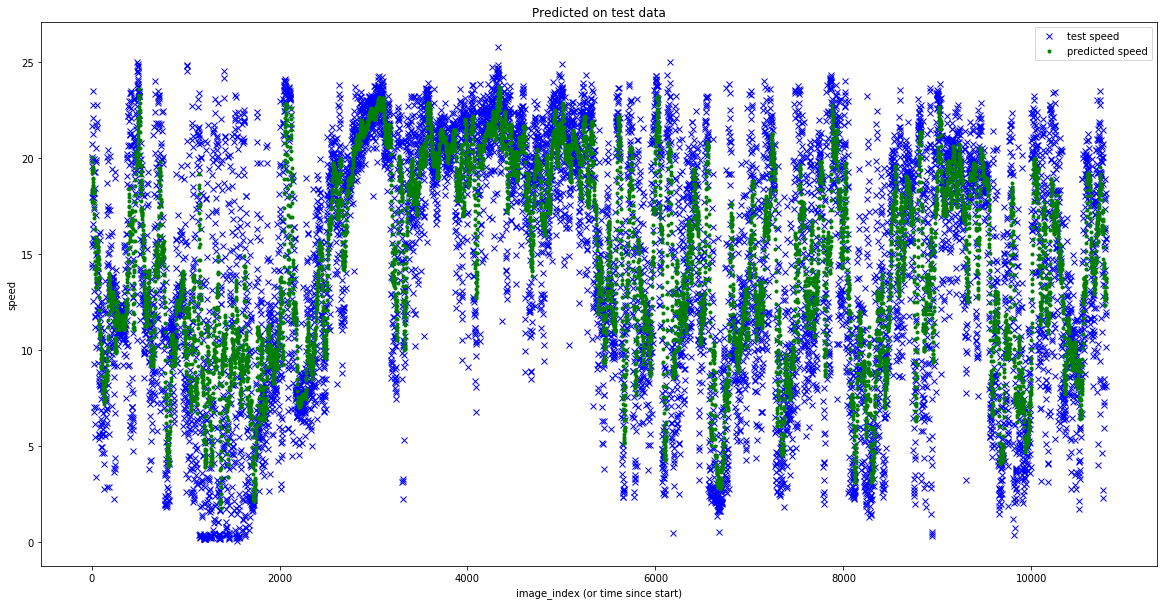

In [211]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['test speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [212]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(DATA_PATH, 'test-02.txt'), index=False)

In [213]:
output_file.head()

0          NaN
1    20.047270
2    19.812257
3    19.206869
4    19.394675
Name: smooth_predicted_speed, dtype: float64

In [214]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['frame'].values[0]
        time_prev = row_prev['frame'].values[0]
        time_next = row_next['frame'].values[0]
        
        def inner():
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])

            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])

            prediction = model.predict(img_diff)
            error = abs(prediction-y2)

            #print(prediction, error, time_now)
            data.loc[data['frame']==time_now, 'predicted_speed'] = prediction[0][0]
            data.loc[data['frame']==time_now, 'error'] = error[0][0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
            inner()
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
            inner()

In [215]:
make_predictions(train_meta)

100%|██████████| 20398/20398 [09:03<00:00, 37.55it/s]


In [217]:
window_size = 25
train_meta['smooth_predicted_speed'] = train_meta['predicted_speed'].rolling(window_size, min_periods=1).mean()
train_meta['smooth_error'] = train_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

train_meta['smooth_predicted_speed'] = train_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

train_meta['smooth_error'] = train_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

In [218]:
train_meta.head()

,image_path,frame,time,speed,predicted_speed,error,smooth_predicted_speed,smooth_error
0,./data/IMG/0.jpg,0,0.00,28.105569,NaN,NaN,NaN,NaN
1,./data/IMG/1.jpg,1,0.05,28.105569,24.746147,3.359423,24.746147,-3.359422
2,./data/IMG/2.jpg,2,0.10,28.106527,26.557045,1.549482,25.651596,-2.454931
3,./data/IMG/3.jpg,3,0.15,28.130404,27.021559,1.108845,26.108250,-2.022154
4,./data/IMG/4.jpg,4,0.20,28.109243,25.757927,2.351316,26.020669,-2.088574


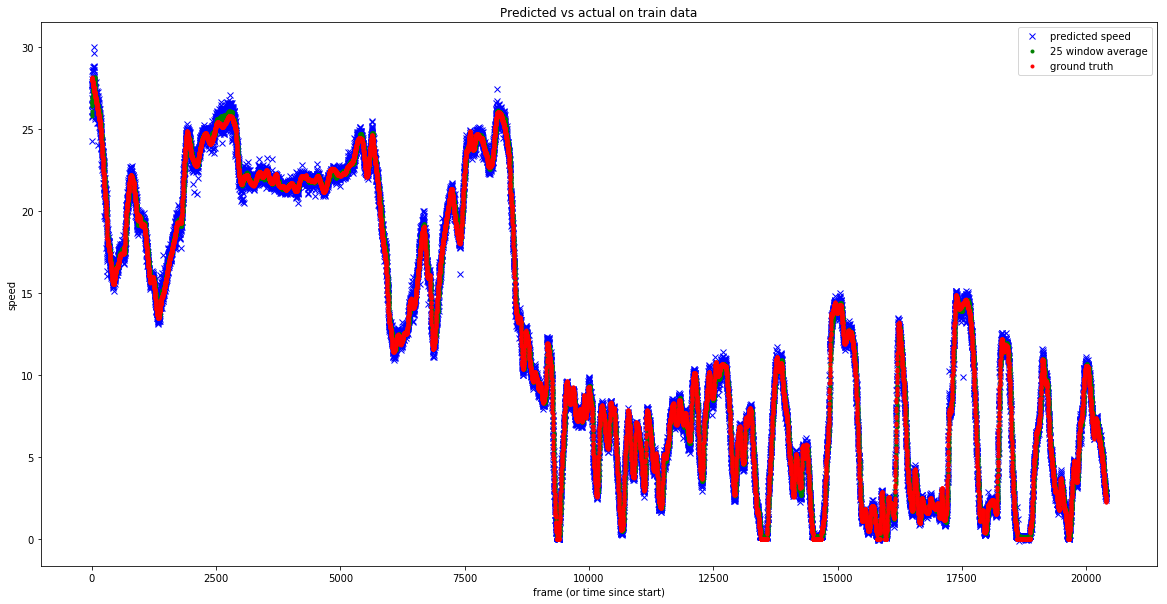

In [112]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_meta.sort_values(['frame'])[['frame']], 
         train_meta.sort_values(['frame'])[['predicted_speed']], 'bx')
plt.plot(train_meta.sort_values(['frame'])[['frame']], 
         train_meta.sort_values(['frame'])[['smooth_predicted_speed']], 'g.')
plt.plot(train_meta.sort_values(['frame'])[['frame']], 
         train_meta.sort_values(['frame'])[['speed']], 'r.')
plt.xlabel('frame (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [113]:
print(mean_squared_error(train_meta.iloc[1:-1, 3], 
                         train_meta.iloc[1:-1, 6]))

0.2278027301322282
